# AFM Particle Detection and Average Particle Separation

http://pythonvision.org/basic-tutorial/<br>http://mahotas.readthedocs.io/en/latest/

In [1]:
%pylab inline
import mahotas as mh
import numpy as np
import scipy as sp
from numpy import linalg as la
import cv2
import pandas as pd
import os
from scipy.optimize import curve_fit

Populating the interactive namespace from numpy and matplotlib


## Convert image to grayscale
Code from "https://codedump.io/share/AbxxuPPXSXZQ/1/how-can-i-convert-an-rgb-image-into-grayscale-in-python"

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114]) 

## Import picture
update filename [par] and directory [cd] as needed

In [3]:
#dire="//Users/alex/backups/Particle Separation Analysis Photos"
#os.chdir(dire)
file='PtnanoCenk0.5et_171218_AM.0_00002_1.png'
par=255*imread(file)



## Show Image and Crop Scales
verify crop image shows entire picture 
if necessary adjust [ipx] and [ipy]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


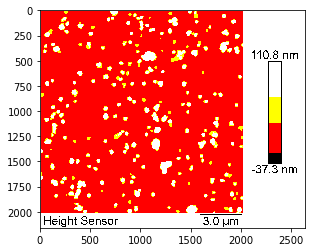

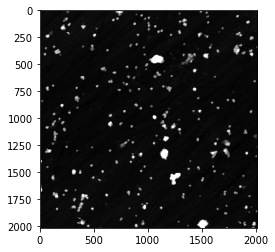

In [4]:
figure()
imshow(par)
gray()
parg = rgb2gray(par)    #convert image from rgb to gray
figure()
ipx=2015   #AFM exported image pixel count
ipy=2015   #AFM exported image pixel count
pargc=parg[2:ipy,2:ipx] # crop image 
imshow(pargc)  #  gray cropped image 

## Scales From Image
Read and input scale values from image

In [5]:
bars=3     # barscale length          |  um
hl=110.8  # low height scale limit   |  nm
hh=-37.3  # high height scale limit  |  nm

## Read Scale bar from image

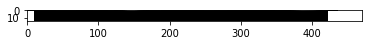

In [6]:
imshow(parg[2015:2030,1580:2050])
scal=parg[2030,0:2000]
bar=np.count_nonzero(scal-255)
pc=bars/bar #pixel to um scale conversion


## Convert image to black and white using bimodal histogram distribution separation 
pixels and background
initial bimodal threshold, observe any adjustments necessary such as adjusting background or minimizing high pixel values (changes height but not area)

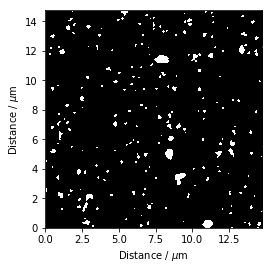

In [7]:
T=mh.thresholding.otsu(pargc.astype(uint8))  #otsu bi-modal histogram thresholding  https://en.wikipedia.org/wiki/Otsu%27s_method
figure()
imshow(pargc>T,extent=[0,pc*ipx,0,pc*ipy])
xlabel('Distance / $\mu$m')
ylabel('Distance / $\mu$m')
show()

## Histogram analysis for Thresholding
verify that the calculated threshold is appropriate. This can have errors when the distribution is not bi modal

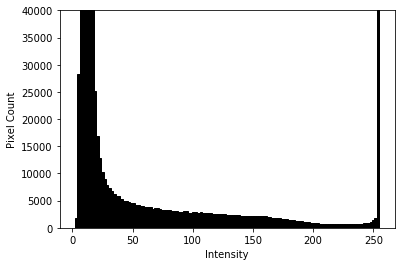

96


In [8]:
h=hist(pargc.ravel(),bins=int(255/2),fc='k', ec='k')
xlabel('Intensity')
ylabel('Pixel Count')
ylim([0,40000])
show()
print(T)

In [9]:
#multi gaussian fit code from:
#https://stackoverflow.com/questions/35990467/fit-two-gaussians-to-a-histogram-from-one-set-of-data-pytho

#xh=h[1]
#yh=np.append(0,h[0])

#plt.plot(xh,yh)
#show()

#from scipy.optimize import curve_fit


#x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

#def gauss(x,mu,sigma,A):
    #return A*exp(-(x-mu)**2/2/sigma**2)

#def nmodal(x,mu1,sigma1,A1,mu2,sigma2,A2,mu3,sigma3,A3,mu4,sigma4,A4,mu5,sigma5,A5):#mu3,sigma3,A3,mu4,sigma4,A4,
    #return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)+gauss(x,mu3,sigma3,A3)+gauss(x,mu4,sigma4,A4)+gauss(x,mu5,sigma5,A5)#+gauss(x,mu3,sigma3,A3)+gauss(x,mu4,sigma4,A4)

#plt.plot(xh,nmodal(xh,8,1,1.4e6,20,1,5.5e5,100,20,4.5e3,160,20,3e3,271,3,4e10),xh,yh)
#ylim([0,40000])
#show()

#expected=(8,1,1.4e6,20,1,5.5e5,26,6,4.5e4,47,1,1e4,271,3,4e10)#100,50,5.5e3,160,50,3e3,
#params,cov=curve_fit(nmodal,xh,yh,expected)
#sigma=sqrt(diag(cov))
#plot(xh,nmodal(xh,*params),color='red',lw=3,label='model')
#legend()
#print(params,'\n',sigma) 



## Manual thresholding
In the case that there is multimodal data (>2)
If there are large particles (peak on histogram above at 255) can shrink data to maximum size of rest of data to remove effect on threshold [1st line]

move all backgroud data to 0 manually using [Ts1] from above histogram
Adjust 


C:\ProgramData\Miniconda3\lib\site-packages\mahotas\internal.py:112: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(A.dtype, np.float):


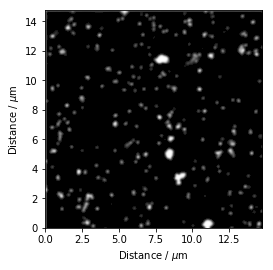

48.0 164


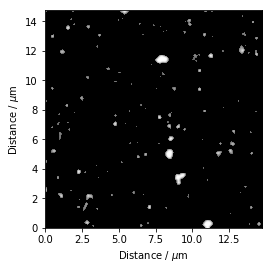

In [11]:
Ti=255                                                 #Initial upper threshold 
pargc[pargc>Ti]=Ti                                  #minimizing large data points to not skew histogram
pargcf = mh.gaussian_filter(pargc, 8).astype('uint8')  #gaussian filter for noise reduction
Ts1=20                                                #manual filter limit based upon histogram above


pargcf[pargcf<Ts1]=0


#multimodal fit (>2)
pargcfs=np.copy(pargcf)  #smaller range (2 particle peaks)
pargcfb=np.copy(pargcf)  #bigger range

#pargcfs[pargcf>1*T]=Ts1      #to account for need of multimodal(>2) fit, which is not capable in python with mahotas or opencv 
Ts = 0.5*mh.thresholding.otsu(pargcfs,1)

pargcfb[pargcf<T]=0
#pargcfb[pargcf>0.2*T]=0

Tb = mh.thresholding.otsu(pargcfb,1)
#pargcfb[pargcf<Ts]=pargcf[pargcf<Ts]
#for non monodispersed and multpile base (?) sized particles

#pargcfs=np.copy(pargcfb)
#Ts=np.copy(Tb)

# In the case of bimodal distribution use the below 2 lines
#pargcfs=pargcf
#Ts=T

figure()
imshow(pargcfs ,extent=[0,pc*ipx,0,pc*ipy])
xlabel('Distance / $\mu$m')
ylabel('Distance / $\mu$m')
show()

print(Ts,Tb)
figure()
imshow(pargcfb,extent=[0,pc*ipx,0,pc*ipy])
xlabel('Distance / $\mu$m')
ylabel('Distance / $\mu$m')
show()


### Graph a) Minimized peak heights for the large particles in an attempt to make a bimodal histogram

Graph b) Smoothed background removing smaller particles for a bimodal distribution

### Verification that the data is thresholded properly

Adjust the thresholded value if graph is not representative

199


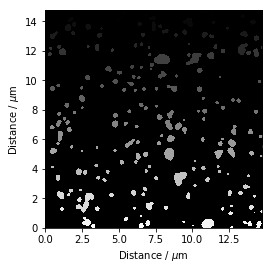

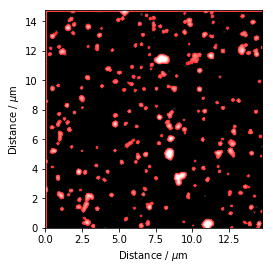

In [12]:
labeled,nr_objects = mh.label(pargcfs > 0.7*Ts)  #all pixels in "one" particle same value
print(nr_objects)
imshow(labeled,extent=[0,pc*ipx,0,pc*ipy])
xlabel('Distance / $\mu$m')
ylabel('Distance / $\mu$m')
show()

figure()    
imshow(mh.overlay(pargcf,labeled),extent=[0,pc*ipx,0,pc*ipy])
xlabel('Distance / $\mu$m')
ylabel('Distance / $\mu$m')
show()

## Gaussian Fit to isolate particles
check Gaussian pixel fit to identify particles correctly. A good starting point is 8, with other common values (from experience) being 12,16,24,30

C:\ProgramData\Miniconda3\lib\site-packages\mahotas\internal.py:112: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(A.dtype, np.float):


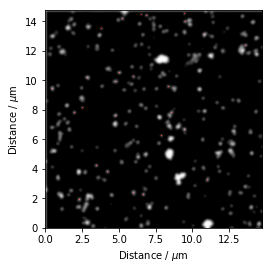

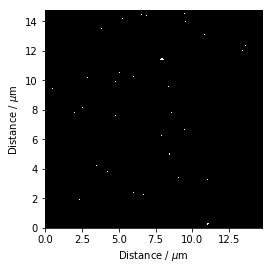

In [13]:
gf=5  # gaussian pixel fit
pargcfs = mh.gaussian_filter(pargcfs, gf).astype('uint8')
Bc_ = np.ones((3,3))
rmaxg = mh.regmax(pargcfs,Bc=Bc_)

imshow(mh.overlay(pargcfs, rmaxg), extent=[0,pc*ipx,0,pc*ipy])
xlabel('Distance / $\mu$m')
ylabel('Distance / $\mu$m')
show()


figure()
imshow(rmaxg, extent=[0,pc*ipx,0,pc*ipy])
gray()
xlabel('Distance / $\mu$m')
ylabel('Distance / $\mu$m')
show()



## Distance Transformation and watershed
reformating particles into spheres (distance transform) followed by inversion to set up watershed (particle identification and labeling)

may need to adjust Threshold value [Ta] and [thr] via dist.mean value

262
10.31234950960831
54


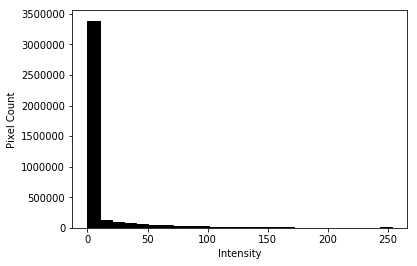

54


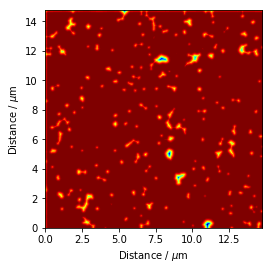

255.0
<class 'numpy.ndarray'>


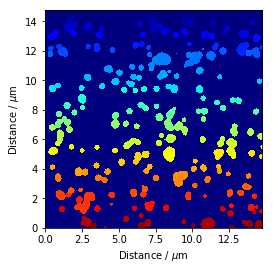

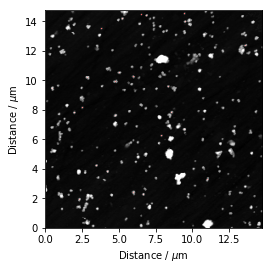

In [14]:
spots,n_spots = mh.label(rmaxg)
print(n_spots)
print(np.mean(pargcfs))
Ta = 1*mh.thresholding.otsu(pargcfs,0)
print(Ta)
h=hist(pargcfs.ravel(),bins=int(255/10),fc='k', ec='k')
xlabel('Intensity')
ylabel('Pixel Count')
show()
print(Ta)
dist = mh.distance(pargcfs > 0.05*Ta)   ###pargcfs

dist = dist.max() - dist#
dist -= dist.min()# inverting color
dist = dist/float(dist.ptp()) * 255
dist = dist.astype(np.uint8)
dist=mh.stretch(dist,0,255)
figure()
imshow(dist, extent=[0,pc*ipx,0,pc*ipy])
jet()
xlabel('Distance / $\mu$m')
ylabel('Distance / $\mu$m')
show()                                                                             #1

th=np.median(dist)#.mean()
thr=(dist < th)  #not accurate to particles detected(?) but matches dist graph well
print(th)
areas = 0.9*mh.cwatershed(dist, labeled)#spots) #labeled
areas = areas*thr
print(type(areas))
figure()
imshow(areas, extent=[0,pc*ipx,0,pc*ipy])                                 #2
xlabel('Distance / $\mu$m')
ylabel('Distance / $\mu$m')
show()


figure()
imshow(mh.overlay(pargc,rmaxg), extent=[0,pc*ipx,0,pc*ipy])               #3
gray()
xlabel('Distance / $\mu$m')
ylabel('Distance / $\mu$m')
show()


In [15]:
print(type(areas))
np.unique(areas)

<class 'numpy.ndarray'>


array([  0. ,   0.9,   1.8,   2.7,   3.6,   4.5,   5.4,   6.3,   7.2,
         8.1,   9. ,   9.9,  10.8,  11.7,  12.6,  13.5,  14.4,  15.3,
        16.2,  17.1,  18. ,  18.9,  19.8,  20.7,  21.6,  22.5,  23.4,
        24.3,  25.2,  26.1,  27. ,  27.9,  28.8,  29.7,  30.6,  31.5,
        32.4,  33.3,  34.2,  35.1,  36. ,  36.9,  37.8,  38.7,  39.6,
        40.5,  41.4,  42.3,  43.2,  44.1,  45. ,  45.9,  46.8,  47.7,
        48.6,  49.5,  50.4,  51.3,  52.2,  53.1,  54. ,  54.9,  55.8,
        56.7,  57.6,  58.5,  59.4,  60.3,  61.2,  62.1,  63. ,  63.9,
        64.8,  65.7,  66.6,  67.5,  68.4,  69.3,  70.2,  71.1,  72. ,
        72.9,  73.8,  74.7,  75.6,  76.5,  77.4,  78.3,  79.2,  80.1,
        81. ,  81.9,  82.8,  83.7,  84.6,  85.5,  86.4,  87.3,  88.2,
        89.1,  90. ,  90.9,  91.8,  92.7,  93.6,  94.5,  95.4,  96.3,
        97.2,  98.1,  99. ,  99.9, 100.8, 101.7, 102.6, 103.5, 104.4,
       105.3, 106.2, 107.1, 108. , 108.9, 109.8, 110.7, 111.6, 112.5,
       113.4, 114.3,

## Particle Distribution
Calculation of size and surface density calculation
Verify labeled areas correlate to above thresholded image 

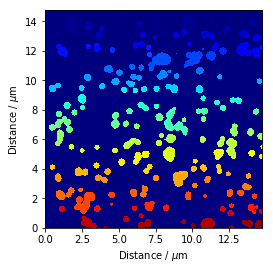

average particle radius: 3.1028e-01 +- 1.3504e-03 um
median particle radius: 2.2786e-01 +- 1.3504e-03 um
number of particles: 150


Text(0,0.5,'Particle count')

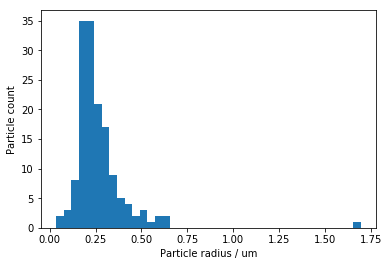

In [16]:
Bc1= np.ones((9,9))
seeds,n_seeds = mh.label(areas,Bc=Bc1)
#seeds=np.copy(spots)
#n_seeds=np.copy(n_spots)

sp=np.where(seeds)
imshow(seeds, extent=[0,pc*ipx,0,pc*ipy])
jet()
xlabel('Distance / $\mu$m')
ylabel('Distance / $\mu$m')
show()

locg=mh.center_of_mass(pargc,seeds)       # location for each seed
locg=locg.astype(int)

sg = mh.labeled.labeled_size(seeds)
pr_mean=np.sqrt(mean(sg[1:])/np.pi)*pc   #average particle radius assuming circular shape
sg=np.sqrt(sg[1:]/np.pi)*pc              #particle radius assuming circular shape
pr_med=np.median(sg)
pr_std=np.sqrt(std(sg[1:])/np.pi)*pc
print('average particle radius: %1.4e +- %1.4e um'%(pr_mean,pr_std))
print('median particle radius: %1.4e +- %1.4e um'%(pr_med,pr_std))
print('number of particles: %.0f'%n_seeds)
#hist(seeds.ravel()):
figure()
hist(sg, bins=40)#,range=(0,10));
xlabel('Particle radius / um')
ylabel('Particle count')

## Particle Separation Analysis
Calculating the partilce separation
Normalization and pythagorean separation show extremely close calculation fo particle separation so that they are in agreement with one another. 

Particle density: 0.6913992646078351 particles/um^2
Average particle separation is: 7.8626e-01 +- 2.3977e-01 um
Average minimum particle norm is: 7.8665e-01 +- 2.3988e-01 um


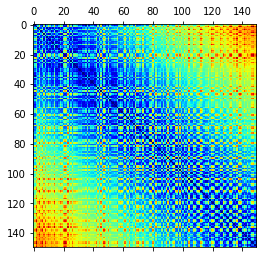

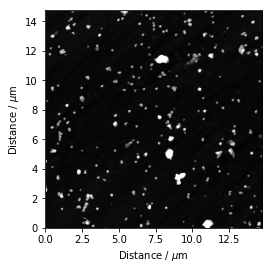

In [29]:
xsg,ysg=rmaxg.shape
x=xsg*pc  #x image length    um
y=ysg*pc  #y image length    um
rho=n_seeds/(y*x)   #particle density
print('Particle density:',rho,'particles/um^2') #
xa=np.linspace(0,x,ipx)
ya=np.linspace(0,y,ipy)
rmaxp=np.where(rmaxg)

dmi=np.empty(len(locg[:,0])-1) #initialize empty array of minimum particle distance for each particle
d=np.empty([len(locg[:,0])-1,len(locg[:,0])-1])
da=np.empty(len(locg[:,0])-1)
a=0
#print(locg)
xloc=np.empty([1,2])
for s in range(0,len(locg[:,0])-1):
    dm=np.empty(len(locg[:,0])-1)   #distance between particle S and every other particle
    for ss in range(0,len(locg[:,0])-1):

        d[s,ss]=norm(locg[s,:]-locg[ss,:])
        dm[ss]=np.sqrt(np.square(xa[locg[s,0]]-xa[locg[ss,0]])+np.square(ya[locg[s,1]]-ya[locg[ss,1]]))

    dmi[s]=np.amin(dm[np.nonzero(dm)])
    da[s]=np.amin(d[s,np.nonzero(d[s,:])])
    if da[s]/sg[s]>3: #thresholded value
        xloc[a,[0,1]]=locg[s,:]
        xloc=np.pad(xloc,[(0,1),(0,0)],'constant',constant_values=[0])
        a=a+1

#print(xloc)
#l,w=np.shape(xloc)
#mask=np.ones((l,w),dtype=bool)
#mask[0:int((l+1)/2),2:w]=False
#xloc=(np.reshape(xloc[mask,...],(-1,2)))
#xloc=xloc[int(l/2),:]
#print(xloc)

da_mean = np.mean(da)*pc
da_std = np.std(da)*pc
print('Average particle separation is: %1.4e +- %1.4e um'%(np.mean(dmi),np.std(dmi)))#%1.4e cm-3' % (Pb)
print('Average minimum particle norm is: %1.4e +- %1.4e um'%(da_mean,da_std))
matshow(d);
jet()



figure()
imshow(pargc, extent=[0,pc*ipx,0,pc*ipy])               #3
#plot(xloc)#mh.overlay(pargc,xloc)

gray()
xlabel('Distance / $\mu$m')
ylabel('Distance / $\mu$m')
show()

In [30]:
spr=np.mean(dmi)/np.mean(sg)
print('separation-particle size ratio:',spr)


separation-particle size ratio: 2.946002716213664


In [31]:
ssx=pc*ipx
ssy=pc*ipy

### Pause before storing results and parameters

In [ ]:
input('Press enter to continue')

### Store results and parameters of results in one file

In [ ]:
df=pd.read_csv("/Users/alex/backups/Particle Separation Analysis Photos/Particle Analysis.csv")
dfp=pd.read_csv("/Users/alex/backups/Particle Separation Analysis Photos/Particle Analysis Parameters.csv")

df=df.append({'dir':dire,'file':file,'pr_mean':pr_mean,'pr_med':pr_med,'pr_std':pr_std,'da_mean':da_mean,'da_std':da_std,'rho':rho,'spr':spr,'ssx':ssx,'ssy':ssy,'n_seeds':n_seeds},ignore_index=True)
dfp=dfp.append({'dir':dire,'file':file,'Ti':Ti,'Ts1':Ts1,'Ts':Ts,'Tb':Tb,'gf':gf,'Ta':Ta,'thr':th},ignore_index=True)
print(df)
print(dfp)
df.to_csv("/Users/alex/backups/Particle Separation Analysis Photos/Particle Analysis.csv")
dfp.to_csv("/Users/alex/backups/Particle Separation Analysis Photos/Particle Analysis Parameters.csv")